In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import NirGBAltBioDataModule, NirGBAltBioModule, utils
import pytorch_lightning as pl
import torch 
from tqdm import tqdm
import torchvision
import pandas as pd 
from pathlib import Path
from skimage import io  
import matplotlib.pyplot as plt
import numpy as np
import collections

In [4]:
dm = NirGBAltBioDataModule(batch_size=700, 
                           num_workers=6, 
                           pin_memory=True,
                        )

dm.setup()

train: 1587395
val: 40080
test: 36421


In [6]:
dm = NirGBAltBioDataModule(batch_size=700, 
                           num_workers=6, 
                           pin_memory=True,
                           train_trans={
                                    "HorizontalFlip": {"p": 0.5},
                                    "VerticalFlip": {"p": 0.5},
                                    "Rotate": {"limit": 30, "p": 0.9},
                                    #"RandomBrightnessContrast": {"brightness_limit": 0.1, "contrast_limit": 0.1, "p": 0.8},
                                })
dm.setup()

train: 1587395
val: 40080
test: 36421


In [7]:
ds = dm.ds_train

In [8]:
alt_sample = ds[0]["img"][:,:,3:]

In [9]:
ds[0]["lat"], ds[0]["lon"]

(45.70511627197271, 1.4246221780776998)

In [10]:
alt_sample.mean()

382.2574462890625

In [11]:
img = utils.get_patch_landcover(ds[20000]["observation_id"])
img = io.imread(img)
plt.imshow(img)
land = np.unique(img)
land

KeyError: 'observation_id'

In [35]:
z = np.zeros(34)
f = lambda v: (img == v).sum() / 65536
v = [f(v) for v in land]
z[land] += v
z

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13142395, 0.21578979, 0.47149658, 0.16435242, 0.        ,
       0.01693726, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [17]:
ds = dm.ds_test

In [19]:
ds[0]["img"][0]

array([[114,  93,  76, 125],
       [116,  96,  77, 125],
       [102,  78,  58, 125],
       ...,
       [ 82,  55,  47, 117],
       [ 86,  60,  52, 117],
       [ 95,  65,  58, 117]], dtype=int16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


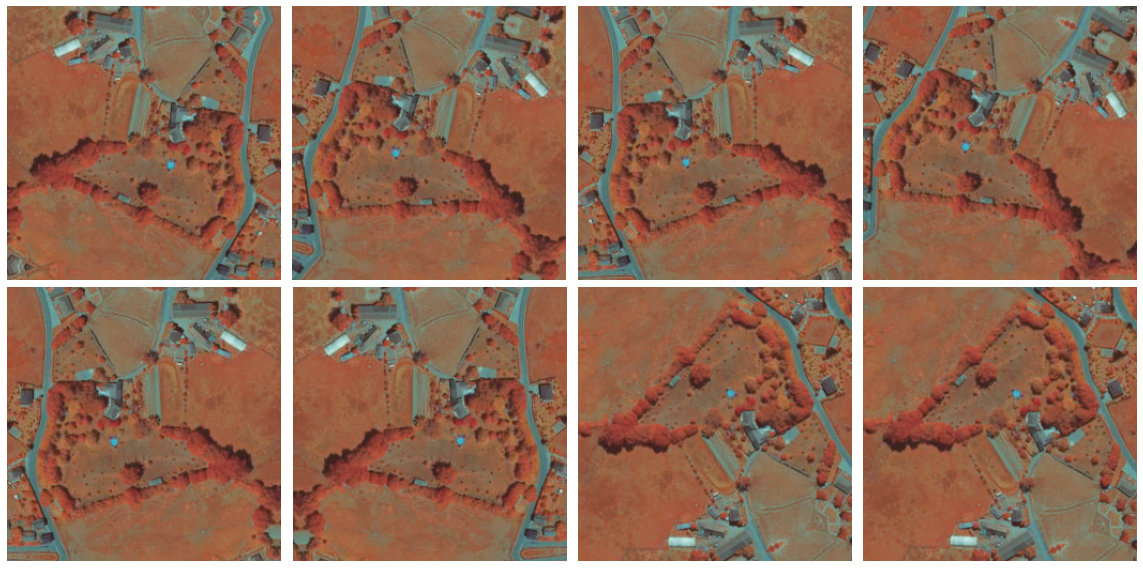

In [14]:
def plot_imgs():
    r, c = 2, 4
    fig = plt.figure(figsize=(4*c, 4*r))
    ds = dm.ds_train
    ix = 0
    for _r in range(r):
        for _c in range(c):
            ax = plt.subplot(r, c, _r*c + _c + 1)
            sample = ds[ix]
            plt.axis("off")
            plt.imshow(sample["img"])
            #plt.title(sample["label"].item())
    plt.tight_layout()
    plt.show()
    
plot_imgs()

In [51]:
config = {
    'backbone': 'resnet34',
    'pretrained': True,
    'optimizer': 'Adam',
    'num_bio': 30,
    'bio_layers': [256, 512],
    'bio_dropout': 0.,
    'optimizer_params': {
        'lr': 1e-3
    },
    'early_stopping': False,
    'trainer': {
        'gpus': 1,
        'max_epochs': 1,
        'logger': None,
        'enable_checkpointing': True,
        'overfit_batches': 0,
        'deterministic': True,
        'precision': 16
    },
    'datamodule': {
        'batch_size': 700,
        'num_workers': 6,
        'pin_memory': True
    },
}

if __name__ == "__main__":
    model = NirGBAltBioModule(config)
    trainer = pl.Trainer(**config["trainer"], resume_from_checkpoint="checkpoints/configs/r34NirGBAltBio-val_loss=6.29144-epoch=1.ckpt")
    #model = NirGBAltBioModule.load_from_checkpoint("checkpoints/configs/r34NirGBAltBio-val_loss=6.29144-epoch=1.ckpt")
    trainer.fit(model, dm)
    model.hparams

Using 16bit native Automatic Mixed Precision (AMP)
d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:51: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:805: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v2.0. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  ckpt_path = ckpt_path or self.resume_from_checkpoint
d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611:

train: 1587395
val: 40080
test: 36421


d:\Code\Kaggle_Competitions\GeoLifeCLEF2022\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:1718: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val_loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': False}"].
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | ResNet     | 21.3 M
1 | bio_mlp    | Sequential | 139 K 
2 | classifier | Linear     | 17.5 M
------------------------------------------
38.9 M    Trainable params
0         Non-trainable params
38.9 M    Total params
77.781    Total estimated model params size (MB)
Restored all states from the checkpoint file at checkpoints/configs/r34NirGBAltBio-val_loss=6.29144-epoch=1.ckpt


In [68]:
model.cuda()
dl = dm.test_dataloader()
labels_epochs = []
labels, observations = [], []
for i in tqdm(range(5)):
    for batch in tqdm(dl):
        preds = model.predict(batch)
        values, ixs = preds.topk(30)
        labels += ixs.tolist()
        if i==0:
            observation_ids = batch["observation_id"]
            observations += observation_ids.numpy().tolist()
    labels_epochs.append(labels)

100%|██████████| 53/53 [00:40<00:00,  1.31it/s]


In [55]:
l1 = [[1,2,3], [4,5,6], [7,8,9]]
l2 = [[10,11,12], [13,14,15], [16,17,18]]
l1 + l2

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18]]

In [70]:
def top30unique(l):
    ltop = []
    i = 0
    while len(ltop) < 30:
        if l[i] not in ltop:
            ltop.append(l[i])
        i += 1
        
    return ltop

In [118]:
labels_merged = []
for i in tqdm(range(len(observations))):
    obs = []
    for j in range(30):
        for e in labels_epochs:
            obs.append(e[i][j])
    top_obs = top30unique(obs)
    labels_merged.append(" ".join([str(i) for i in top_obs]))

100%|██████████| 36421/36421 [00:01<00:00, 33660.87it/s]


In [119]:
import pandas as pd
submission = pd.DataFrame({"Id": observations, "Predicted": labels_merged})
#submission["Id"] = submission["Id"].astype(int)
submission.to_csv("submission.csv", index=False)
submission.sample(5)

,Id,Predicted
33924,21796462,6038 5754 1561 7378 7146 5033 5936 7144 5613 1...
28417,21209767,5996 5135 6303 10438 257 5796 7179 7920 11788 ...
16056,10809763,521 1257 294 45 699 676 552 110 798 912 55 485...
4637,10025907,362 97 270 21 250 5 373 565 442 576 90 169 26 ...
2393,10182907,12 981 431 767 538 465 634 301 883 1725 218 12...


In [120]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
assert len(sample_submission) == len(submission)
sample_submission.sample(10)

,Id,Predicted
8041,10382527,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4535,10215395,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
30637,21445852,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
6297,10297627,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
9698,10461388,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
8052,10383036,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
26923,21049762,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
24047,20737951,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
8760,10417347,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
25553,20902527,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [114]:
len(sample_submission)

36421

In [116]:
len(submission) / 5

36421.0

In [117]:
observations = observations[:36421]

In [21]:
import pandas as pd
import torch

In [29]:
torch.tensor([2,3,4])

tensor([2, 3, 4])